In [403]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [404]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [405]:
start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)

bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']


df = yf.download(bank_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  8 of 8 completed


In [406]:
bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']

In [407]:
df.loc["2022-01-01" : "2023-01-01"].to_csv('bank_train.csv')
df.loc["2023-01-01" : "2025-01-01"].to_csv('bank_test.csv')

In [408]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [409]:
df_train = pd.read_csv('bank_train.csv', index_col='Date',parse_dates=True)


In [410]:
res = coint_johansen(df_train[bank_tickers], det_order = 1, k_ar_diff = 1)

In [411]:
res.lr1

array([173.34326955, 118.69213613,  82.3005562 ,  54.45114642,
        33.62452429,  19.79995059,   9.04371417,   0.46155552])

In [412]:
res.cvt

array([[169.0618, 175.1584, 187.1891],
       [133.7852, 139.278 , 150.0778],
       [102.4674, 107.3429, 116.9829],
       [ 75.1027,  79.3422,  87.7748],
       [ 51.6492,  55.2459,  62.5202],
       [ 32.0645,  35.0116,  41.0815],
       [ 16.1619,  18.3985,  23.1485],
       [  2.7055,   3.8415,   6.6349]])

In [413]:
res.lr2

array([54.65113342, 36.39157993, 27.84940978, 20.82662213, 13.8245737 ,
       10.75623642,  8.58215865,  0.46155552])

In [414]:
res.cvm

array([[52.5858, 55.7302, 62.1741],
       [46.5583, 49.5875, 55.8171],
       [40.5244, 43.4183, 49.4095],
       [34.4202, 37.1646, 42.8612],
       [28.2398, 30.8151, 36.193 ],
       [21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

In [415]:
arb_vec = res.evec[0]

In [416]:
df_test = pd.read_csv('bank_test.csv', index_col='Date',parse_dates=True)

In [417]:
import ffn

In [418]:
def backtest(stock_price_df, coeffs, entryZscore, exitZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 60).mean()
    df['std_30'] = df['spread'].rolling(window = 60).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_long'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe, df['spread']

In [419]:
from pykalman import KalmanFilter

In [420]:
def KF_Avg(x):
    """Smoothens a stock price series, removing all possible noise"""
    kf = KalmanFilter(transition_matrices = [1], ## System Model: priori_price_on_next_day = price_on_last_day
                      observation_matrices = [1], ## Measuring stock price on the next day
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    try:
        state_means, state_covs = kf.filter(x.values) ## x is assumed to be sequential measurements of the stock price
        state_means = pd.Series(state_means.flatten(), index=x.index)
    except:
        state_means, state_covs = kf.filter(x)
    
    return state_means

In [421]:
def backtest_KF(stock_price_df, coeffs, entryZscore, exitZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    for s in stock_names:
        df[s] = KF_Avg(df[s])
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 60).mean()
    df['std_30'] = df['spread'].rolling(window = 60).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_short'] + df['num_units_long']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe

In [422]:
backtest_KF(df_test[bank_tickers], arb_vec, 2, 0)

(Date
 2023-01-02         NaN
 2023-01-03    1.000000
 2023-01-04    1.000000
 2023-01-05    1.000000
 2023-01-06    1.000000
                 ...   
 2024-12-24    0.862187
 2024-12-26    0.860577
 2024-12-27    0.859729
 2024-12-30    0.858300
 2024-12-31    0.858990
 Name: cum rets, Length: 491, dtype: float64,
 -2.8611191979897517)

In [423]:
for bk in bank_tickers:
    df_train[f"{bk}_smooth"] = KF_Avg(df_train[bk])
    df_test[f"{bk}_smooth"] = KF_Avg(df_test[bk])

<Axes: xlabel='Date'>

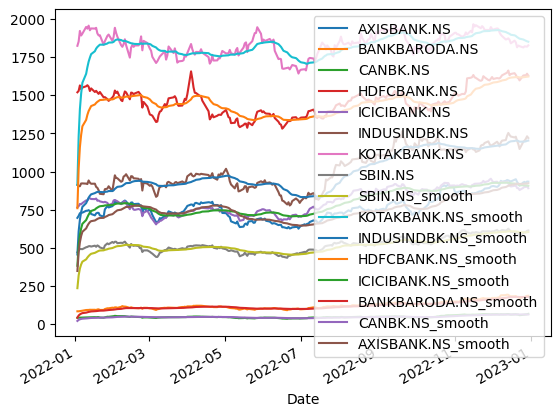

In [424]:
# df_train[bank_tickers].plot()
df_train[df_train.keys()].plot()
# df_train[[f"{bk}_smooth" for bk in bank_tickers].extend(bank_tickers)].plot()

In [425]:
bank_tickers_smooth = [f"{bk}_smooth" for bk in bank_tickers]

In [426]:
ret, sharpe, spread = backtest(df_test[bank_tickers], arb_vec, 1, 0)

start                    2023-01-02 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                0.190326
max_drawdown                       -0.133108
calmar                              1.429856
mtd                                -0.000664
three_month                         0.010403
six_month                           0.080219
ytd                                 0.401403
one_year                            0.401403
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               0.190326
daily_sharpe                        1.308865
daily_sortino                       2.593335
daily_mean                          0.189353
daily_vol                           0.144669
daily_skew                          1.720053
daily_kurt                          10.72637
best_day  

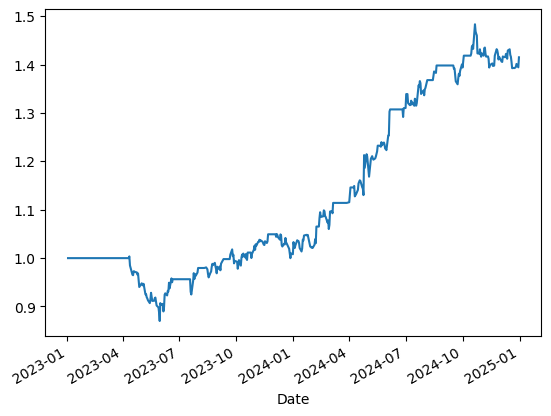

In [427]:
ret.plot()
ret.calc_stats().stats

<Axes: xlabel='Date'>

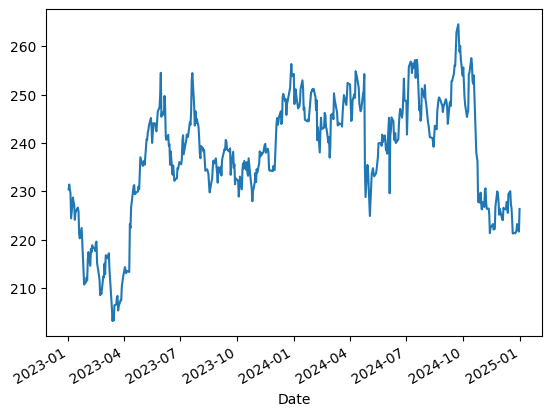

In [428]:
spread.plot()

In [429]:
pharma_tickers = [
    "SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS", "DIVISLAB.NS",
    "AUROPHARMA.NS", "BIOCON.NS", "LUPIN.NS", "TORNTPHARM.NS",
    "ZYDUSLIFE.NS", "GLENMARK.NS"
]


start = datetime(2021, 1, 1)
end = datetime(2025, 1, 1)
df = yf.download(pharma_tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  10 of 10 completed


Ticker,AUROPHARMA.NS,BIOCON.NS,CIPLA.NS,DIVISLAB.NS,DRREDDY.NS,GLENMARK.NS,LUPIN.NS,SUNPHARMA.NS,TORNTPHARM.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,
2024-12-24,1262.449951,344.500000,1475.750000,5782.350098,1350.900024,1535.800049,2169.449951,1819.000000,3399.449951,964.799988
2024-12-26,1256.250000,346.450012,1490.550049,5886.750000,1355.150024,1541.449951,2182.100098,1841.349976,3421.350098,957.650024
2024-12-27,1269.949951,352.549988,1506.599976,5881.049805,1389.449951,1585.949951,2227.800049,1861.250000,3405.100098,972.400024
2024-12-30,1298.300049,367.700012,1521.400024,6045.000000,1376.900024,1589.800049,2311.350098,1883.900024,3369.500000,956.950012
2024-12-31,1334.500000,365.350006,1529.000000,6098.799805,1388.500000,1609.099976,2355.699951,1886.349976,3360.050049,971.700012


In [430]:
df.index = pd.to_datetime(df.index)

In [431]:
df.loc["2021-01-01" : "2023-06-01"].to_csv('pharma_train.csv')

In [432]:
df.loc["2022-07-01" : "2025-01-01"].to_csv('pharma_test.csv')

In [433]:
df_train = pd.read_csv('pharma_train.csv', index_col='Date', parse_dates=True)

In [434]:
res = coint_johansen(df_train[pharma_tickers], det_order = 1, k_ar_diff = 2)

In [435]:
res.cvt

array([[251.6293, 259.0267, 273.3838],
       [208.3582, 215.1268, 228.2226],
       [169.0618, 175.1584, 187.1891],
       [133.7852, 139.278 , 150.0778],
       [102.4674, 107.3429, 116.9829],
       [ 75.1027,  79.3422,  87.7748],
       [ 51.6492,  55.2459,  62.5202],
       [ 32.0645,  35.0116,  41.0815],
       [ 16.1619,  18.3985,  23.1485],
       [  2.7055,   3.8415,   6.6349]])

In [436]:
res.lr1

array([283.51463659, 225.24460526, 177.43647872, 133.84240785,
        90.7419461 ,  61.28507387,  34.78488429,  20.16903051,
        10.35684475,   4.22236632])

In [437]:
res.cvm

array([[64.5292, 67.904 , 74.7434],
       [58.5316, 61.8051, 68.503 ],
       [52.5858, 55.7302, 62.1741],
       [46.5583, 49.5875, 55.8171],
       [40.5244, 43.4183, 49.4095],
       [34.4202, 37.1646, 42.8612],
       [28.2398, 30.8151, 36.193 ],
       [21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

In [438]:
res.lr2

array([58.27003132, 47.80812654, 43.59407087, 43.10046175, 29.45687222,
       26.50018958, 14.61585378,  9.81218576,  6.13447843,  4.22236632])

In [439]:
res.evec[0]

array([ 0.0107773 ,  0.00740783,  0.00322853,  0.0107313 ,  0.02716167,
       -0.01194141,  0.00347235,  0.00490868, -0.00207357,  0.00701014])

In [440]:
df_test = pd.read_csv('pharma_test.csv', parse_dates=True, index_col='Date')

In [441]:
ret = backtest(df_test[pharma_tickers], res.evec[0], 1, 0)

<Axes: xlabel='Date'>

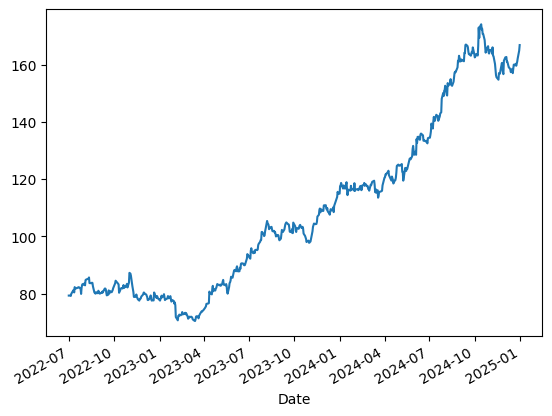

In [442]:
ret[2].plot()

<Axes: xlabel='Date'>

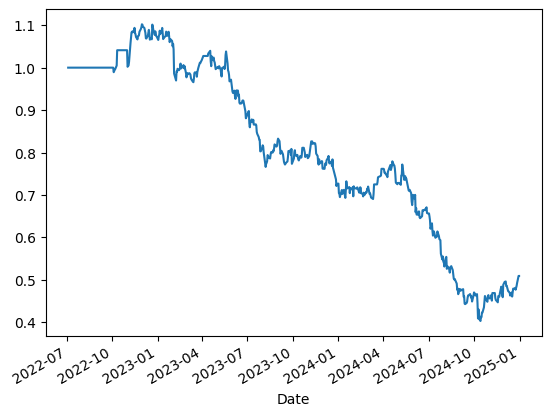

In [443]:
ret[0].plot()

In [444]:
ret[0].calc_stats().stats

start                    2022-07-01 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                               -0.237081
max_drawdown                       -0.634359
calmar                             -0.373732
mtd                                 0.042871
three_month                         0.098988
six_month                          -0.225463
ytd                                -0.298744
one_year                           -0.298744
three_year                         -0.237081
five_year                                NaN
ten_year                                 NaN
incep                              -0.237081
daily_sharpe                       -1.103695
daily_sortino                      -1.641308
daily_mean                         -0.250921
daily_vol                           0.227347
daily_skew                         -0.368148
daily_kurt                          3.910544
best_day  

In [445]:
def KF_linear_regression(x, y):
    """Uses a Kalman Filter to determine the linear regression parameters for stocks x and y"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    ## alpha is intercept, beta is the slope

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance = np.ones((2, 2)),
                      transition_matrices = np.eye(2), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [446]:
x = df_train[['BIOCON.NS', 'CIPLA.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
       'GLENMARK.NS', 'LUPIN.NS', 'SUNPHARMA.NS', 'TORNTPHARM.NS',
       'ZYDUSLIFE.NS']]
y = df_train["AUROPHARMA.NS"]

In [447]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(10) # How much random walk wiggles
filtered_x = x.to_numpy().T
# for i in range(9):
#     filtered_x[i] = KF_Avg(filtered_x[i]).reshape(filtered_x[i].shape)
obs_mat = np.expand_dims(np.vstack([filtered_x, [np.ones(len(x))]]).T, axis=1)

In [448]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=10, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean= np.zeros(10),
                      initial_state_covariance = np.ones((10, 10)),
                      transition_matrices = np.eye(10), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)

In [449]:
# y_fil = KF_Avg(y)
state_means, state_covs = kf.filter(y)

In [450]:
x.values.shape

(598, 9)

In [451]:
state_means.shape

(598, 10)

In [452]:
x_big = np.vstack([x.to_numpy().T, [np.ones(len(x))]]).T

In [453]:
spread = y- np.sum( x_big[:, :9] * state_means[:, :9], axis = 1)

In [454]:
df_train['spread'] = spread

<Axes: xlabel='Date'>

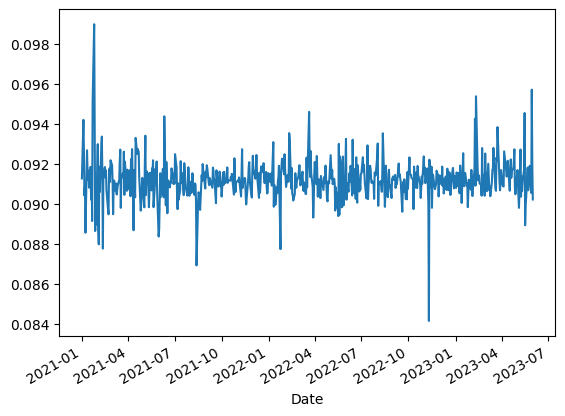

In [455]:
spread.plot()

In [532]:
def backtest_super_KF(stocks_df):
    df = stocks_df.copy()
    stock_names = df.keys()
    num_stocks = len(stock_names)
    x = df[stock_names[1:]]
    y = df[stock_names[0]]
    print(stock_names[0])
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(num_stocks) # How much random walk wiggles
    filtered_x = x.to_numpy().T
    # for i in range(9):
    #     filtered_x[i] = KF_Avg(filtered_x[i]).reshape(filtered_x[i].shape)
    obs_mat = np.expand_dims(np.vstack([filtered_x, [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=num_stocks, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean= np.zeros(num_stocks),
                      initial_state_covariance = np.ones((num_stocks, num_stocks)),
                      transition_matrices = np.eye(num_stocks), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    state_means, state_covs = kf.filter(y)
    x_big = np.vstack([x.to_numpy().T, [np.ones(len(x))]]).T
    df['spread'] = y- np.sum( x_big[:, : num_stocks - 1] * state_means[:, : num_stocks - 1], axis = 1)
    df['mean_30'] = df['spread'].rolling(window = 60).mean()
    df['std_30'] = df['spread'].rolling(window = 60).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    ## Using the same code from the first backtest function
    entryZscore = 1
    exitZscore = 0

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_long'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)
    df['port_val'] = df.spread.diff() * df['numUnits'].shift(1)
    df['port_ret_money'] = df['port_val'].cumsum()
    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0
    df_coeffs = pd.DataFrame({stock_names[i + 1] : state_means[:,i] for i in range(num_stocks - 1)})
    df_coeffs.index = df.index
    
    

    return df['cum rets'], sharpe, df['spread'], df_coeffs, df['numUnits'], df['port_ret_money']
    

In [533]:
res = backtest_super_KF(df_test[pharma_tickers])

SUNPHARMA.NS


In [534]:
spread = res[2]
ret = res[0]
coeffs = res[3]
n_un = res[4]

In [547]:
res[4]

Date
2022-07-01    0.0
2022-07-04    0.0
2022-07-05    0.0
2022-07-06    0.0
2022-07-07    0.0
             ... 
2024-12-24    0.0
2024-12-26    0.0
2024-12-27    0.0
2024-12-30    0.0
2024-12-31    0.0
Name: numUnits, Length: 616, dtype: float64

In [536]:
final_remaining = res[3].T @ res[4]

In [537]:
final_remaining

DRREDDY.NS       0.686629
CIPLA.NS         0.223252
DIVISLAB.NS     -0.016347
AUROPHARMA.NS    0.423623
BIOCON.NS        0.238349
LUPIN.NS         0.032799
TORNTPHARM.NS    0.708369
ZYDUSLIFE.NS     0.258427
GLENMARK.NS      0.300860
dtype: float64

In [538]:
df_test[pharma_tickers].iloc[-1, 1:]

DRREDDY.NS       1388.500000
CIPLA.NS         1529.000000
DIVISLAB.NS      6098.799805
AUROPHARMA.NS    1334.500000
BIOCON.NS         365.350006
LUPIN.NS         2355.699951
TORNTPHARM.NS    3360.050049
ZYDUSLIFE.NS      971.700012
GLENMARK.NS      1609.099976
Name: 2024-12-31 00:00:00, dtype: float64

In [539]:
final_remaining.T @ df_test[pharma_tickers].iloc[-1, 1:]

5040.093751486467

<Axes: xlabel='Date'>

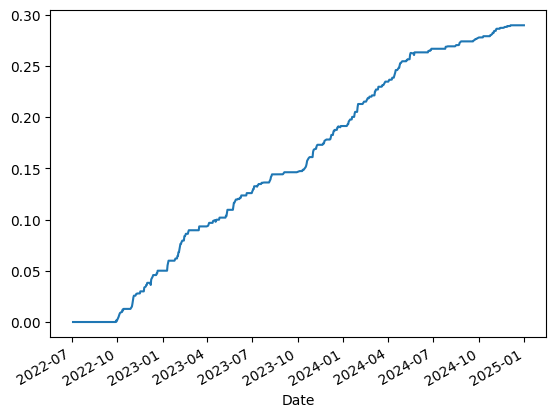

In [544]:
res[5].plot()

<Axes: xlabel='Date'>

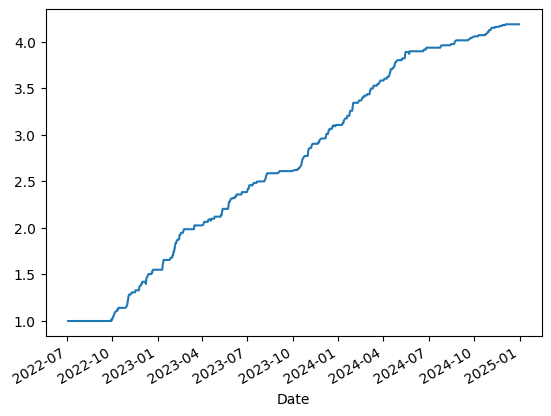

In [545]:
ret.plot()

<Axes: xlabel='Date'>

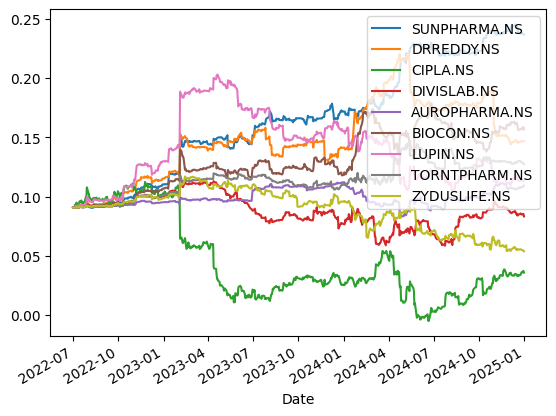

In [462]:
coeffs.plot()

,SBIN.NS,LUPIN.NS,ITC.NS,ADANIPORTS.NS
Date,,,,
2021-01-01,0.105960,0.105960,0.105960,0.105960
2021-01-04,0.105632,0.105892,0.105801,0.105667
2021-01-05,0.105958,0.105957,0.105955,0.105944
2021-01-06,0.111142,0.107042,0.108702,0.110632
2021-01-07,0.110572,0.106940,0.108405,0.110173
...,...,...,...,...
2024-12-24,0.070811,0.364644,0.156222,0.244672
2024-12-26,0.069090,0.365812,0.150124,0.246895
2024-12-27,0.061120,0.366807,0.151960,0.246355


In [463]:
ret.calc_stats().stats

start                    2022-07-01 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                0.775382
max_drawdown                       -0.016669
calmar                              46.51518
mtd                                 0.001945
three_month                         0.032972
six_month                           0.063851
ytd                                 0.348124
one_year                            0.348124
three_year                          0.775382
five_year                                NaN
ten_year                                 NaN
incep                               0.775382
daily_sharpe                        6.150948
daily_sortino                      40.344519
daily_mean                          0.592852
daily_vol                           0.096384
daily_skew                          3.462032
daily_kurt                         16.575934
best_day  

In [464]:
df_test = pd.read_csv('bank_test.csv', index_col='Date',parse_dates=True)

In [465]:
res = backtest_super_KF(df_test[bank_tickers])

In [466]:
ret = res[0]
spread = res[2]
coeffs = res[3]

<Axes: xlabel='Date'>

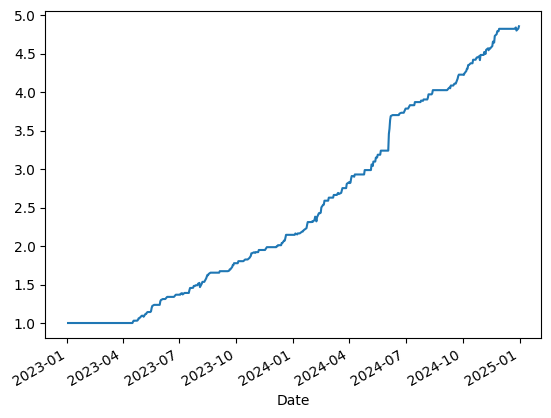

In [467]:
ret.plot()

<Axes: xlabel='Date'>

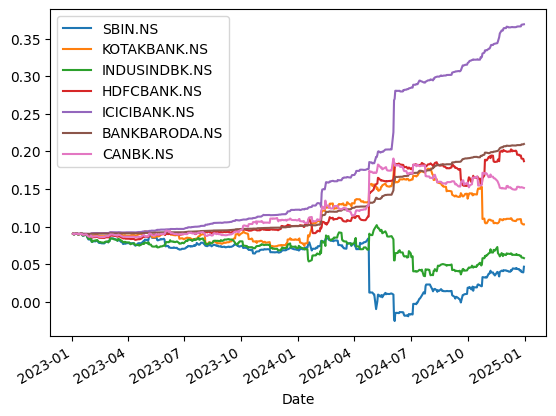

In [468]:
coeffs.plot()

In [469]:
arbitrary_port_tickers = ['SBIN.NS', 'LUPIN.NS', 'ITC.NS', 'ADANIPORTS.NS', 'RELIANCE.NS']
start = datetime(2021, 1, 1)
end = datetime(2025, 1, 1)
df = yf.download(arbitrary_port_tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  5 of 5 completed


Ticker,ADANIPORTS.NS,ITC.NS,LUPIN.NS,RELIANCE.NS,SBIN.NS
Date,,,,,
2024-12-24,1182.199951,478.450012,2169.449951,1222.750000,812.049988
2024-12-26,1243.949951,476.950012,2182.100098,1216.550049,812.450012
2024-12-27,1230.699951,478.600006,2227.800049,1221.050049,799.650024
2024-12-30,1218.500000,477.000000,2311.350098,1210.699951,788.299988
2024-12-31,1231.099976,483.649994,2355.699951,1215.449951,794.950012


In [470]:
df.head()

Ticker,ADANIPORTS.NS,ITC.NS,LUPIN.NS,RELIANCE.NS,SBIN.NS
Date,,,,,
2021-01-01,503.850006,213.850006,1000.900024,917.230957,279.399994
2021-01-04,498.899994,213.399994,1026.949951,918.776978,281.049988
2021-01-05,499.450012,211.449997,1039.949951,907.354858,281.750000
2021-01-06,496.799988,205.399994,1000.599976,883.426086,285.049988
2021-01-07,513.849976,202.800003,1022.250000,881.995422,287.700012


In [471]:
res = backtest_super_KF(df[arbitrary_port_tickers])

In [472]:
ret = res[0]
spread = res[2]
coeffs = res[3]

<Axes: xlabel='Date'>

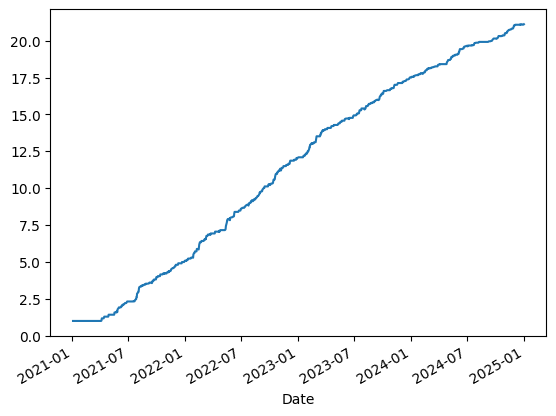

In [473]:
ret.plot()

<Axes: xlabel='Date'>

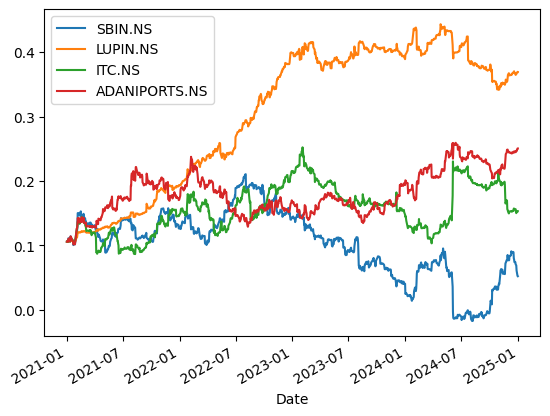

In [474]:
coeffs.plot()

In [475]:
ret.calc_stats().stats

start                    2021-01-01 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                1.147985
max_drawdown                       -0.037137
calmar                              30.91244
mtd                                 0.003643
three_month                         0.048103
six_month                           0.074501
ytd                                 0.206374
one_year                            0.206374
three_year                          0.607685
five_year                                NaN
ten_year                                 NaN
incep                               1.147985
daily_sharpe                        4.510353
daily_sortino                      31.966744
daily_mean                          0.796232
daily_vol                           0.176534
daily_skew                          6.927534
daily_kurt                         64.249375
best_day  

In [476]:
df_train

,AUROPHARMA.NS,BIOCON.NS,CIPLA.NS,DIVISLAB.NS,DRREDDY.NS,GLENMARK.NS,LUPIN.NS,SUNPHARMA.NS,TORNTPHARM.NS,ZYDUSLIFE.NS,spread
Date,,,,,,,,,,,
2021-01-01,927.750000,465.750000,826.599976,3849.050049,1048.270020,502.600006,1000.900024,596.250000,1397.525024,478.399994,0.091275
2021-01-04,965.750000,467.000000,832.250000,3862.250000,1054.449951,514.599976,1026.949951,604.400024,1397.324951,486.399994,0.094203
2021-01-05,979.349976,467.649994,827.250000,3842.100098,1057.380005,517.700012,1039.949951,603.450012,1404.724976,485.850006,0.092576
2021-01-06,968.849976,459.750000,824.799988,3879.850098,1057.660034,520.250000,1000.599976,605.299988,1395.349976,481.600006,0.090420
2021-01-07,957.450012,454.799988,826.549988,3803.050049,1054.180054,514.349976,1022.250000,601.900024,1387.974976,482.200012,0.090886
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-26,614.849976,239.449997,951.349976,3514.000000,906.190002,591.400024,779.950012,969.900024,1700.250000,508.250000,0.091906
2023-05-29,611.299988,242.050003,956.250000,3477.850098,911.250000,594.500000,805.700012,968.450012,1705.949951,512.049988,0.090552
2023-05-30,650.750000,241.649994,959.849976,3458.000000,903.780029,595.450012,803.599976,959.599976,1713.550049,505.750000,0.095709


In [477]:
n = len(pharma_tickers)
poss_comb = {}
for i in range(n - 1):
    for j in range(i + 1, n):
        med_group = pharma_tickers[i:j + 1]
        res = coint_johansen(df_train[med_group], det_order=0, k_ar_diff=2)
        if res.lr1[0] > res.cvt[0][0] and res.lr2[0] > res.cvm[0][0]:
            poss_comb[(i, j + 1)] = res.evec[0]

In [478]:
poss_comb

{(1,
  9): array([ 0.032598  , -0.002509  ,  0.00709595,  0.02147458, -0.00156595,
        -0.00022069, -0.00435875,  0.00553075]),
 (5, 9): array([ 0.03362442,  0.01381071, -0.01041338,  0.00078358])}

In [479]:
comb_ind = list(poss_comb.keys())

In [485]:
group = pharma_tickers[comb_ind[0][0] : comb_ind[0][1]]
coeff_vec = poss_comb[comb_ind[0]]

In [481]:
df_test = pd.read_csv('pharma_test.csv', parse_dates=True, index_col='Date')

In [486]:
ret, sharpe, spread = backtest(df_test[group], coeff_vec, 1, 0)

<Axes: xlabel='Date'>

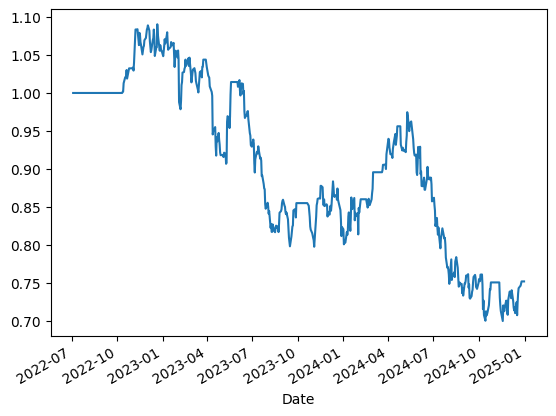

In [487]:
ret.plot()

<Axes: xlabel='Date'>

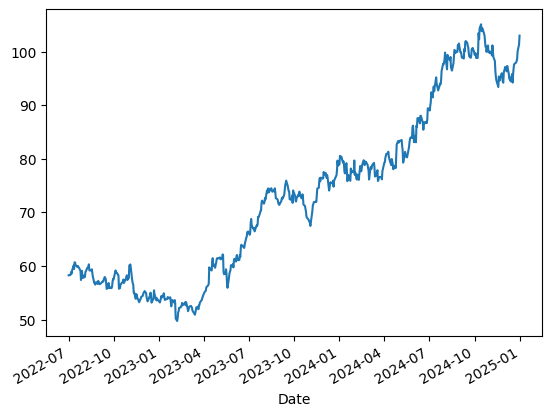

In [488]:
spread.plot()